In [1]:
# make model smaller, 

import os

os.chdir('/home/enis/projects/nna/src/nna/exp/megan/run-2/')


In [2]:
# import run
# import nna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchaudio
torchaudio.set_audio_backend("sox_io")

import numpy as np

from pathlib import Path
from collections import Counter


/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [3]:
torch.manual_seed(42)

np.random.seed(42)

torch.backends.cudnn.benchmark = False

In [4]:
loc_per_set = [['45',
  '38',
  '48',
  '39',
  '11',
  '44',
  '46',
  '17',
  '20',
  '50',
  '13',
  '25',
  '21',
  '29',
  '19',
  '16',
  '24',
  '37'],
 ['18', '31', '34', '27', '32', '33', '47', '41', '22', '15'],
 ['30', '12', '14', '36', '40', '49']]


In [5]:
import runconfigs
import wandb
from ignite.metrics import Accuracy, Loss
from ignite.contrib.metrics import ROC_AUC

In [6]:
# from nna.exp import augmentations,
from nna.exp import modelArchs,runutils

In [7]:
# wandb.init(config=runconfigs.default_config, project=runconfigs.PROJECT_NAME)
# config = wandb.config
config = runconfigs.default_config
# wandb.config.update(args) # adds all of the arguments as config variables
config['batch_size'] = 64
params = {
    'batch_size': config['batch_size'],
    'shuffle': True,
    'num_workers': 0
}


In [8]:
device = torch.device(
    f"cuda:{config['device']}" if torch.cuda.is_available() else "cpu")


In [9]:

# labelsbyhumanpath = Path('/scratch/enis/data/nna/labeling/results/')
# sourcePath = Path("/scratch/enis/data/nna/labeling/splits/")


In [10]:
CATEGORY_COUNT = 2


In [11]:
!ls

job_logs			   start_v3.2.2_smaller-model.ipynb
__pycache__			   start_v3.2_smaller-model.ipynb
runconfigs.py			   start_v3.3.1_smaller-model.ipynb
run.py				   start_v3.3_smaller-model.ipynb
start_v3.1_negative-samples.ipynb  start_v3_split-loc.ipynb
start_v3.2.1_smaller-model.ipynb   wandb


In [12]:
## Load real data rather than mock 
    # MVP1: delete parts longer than 10 seconds
import run
audio_dataset,_ = run.prepare_dataset()

output_file_path = '/scratch/enis/data/nna/labeling/megan/AudioSamplesPerSite/files_as_np_filtered_v3_int16.pkl'
audio_dataset.load_audio_files(output_file_path)
audio_dataset.pick_channel_by_clipping()


/scratch/enis/data/nna/labeling/megan/AudioSamplesPerSite/meganLabeledFiles_wlenV1.txt
/scratch/enis/data/nna/labeling/megan/AudioSamplesPerSite
4 files are missing corresponding to excell entries
'-> 5 number of samples are DELETED due to ignore_files and missing_audio_files'
-> 415 samples DELETED because they are not in the excell

-> 0 samples DELETED because they do not have the taxo info coming from excell

-> classes that do not have enough data:
[REMOVED!]
['other-mammal'] 0.0
['other-silence'] 20.0
['unknown-sound'] 2.0
['seabirds'] 1.0
['canids'] 1.0
['other-flare'] 11.0
['other-rain'] 20.0

-> classes that have enough data:
['other-biophony'] 56.0
['other-insect'] 140.0
['other-bird'] 661.0
['songbirds'] 392.0
['duck-goose-swan'] 183.0
['grouse-ptarmigan'] 59.0
['other-anthrophony'] 66.0
['other-aircraft'] 107.0
['loons'] 29.0
['other-car'] 37.0
('-> 102 number of samples are deleted because their taxonomy category does '
 'not have enough data.')
-> classes that do not have

In [13]:
def data_to_samples(sound_ins,excerpt_len):
    excerpt_sample_size = excerpt_len * sound_ins.sr

    data_len_sec = sound_ins.length
    if data_len_sec<10:
        tile_reps = (excerpt_len / (sound_ins.length) + 1)
        repeated_data = np.tile(sound_ins.data, int(tile_reps))
        repeated_data = repeated_data[:excerpt_len * sound_ins.sr]
        sound_ins.samples = [repeated_data]
        
    elif data_len_sec==10:
        sound_ins.samples = [sound_ins.data]
    else:
        excerpt_count = data_len_sec//10
        data_trim_point = excerpt_count*excerpt_len*sound_ins.sr
        samples = sound_ins.data[:int(data_trim_point)].reshape(-1,int(excerpt_sample_size))
        sample_list = []
        for sample in samples:
            sample_list.append(sample)
        
        sound_ins.samples = sample_list

In [14]:
target_taxo = ['1.1.10', '1.1.7']
other_taxo = ['1.0.0', '2.1.0', '1.3.0', '1.1.8']
# expected_len = 10
excerpt_len = 10
audio_lengths= []
for sound_ins in audio_dataset.values():
#     data_to_samples(sound_ins,excerpt_len)
#     if len(sound_ins.samples)==1:
#         print(len(sound_ins.samples[0]))
    audio_lengths.append(sound_ins.length)


# print(c,data_excerpt_count,t)


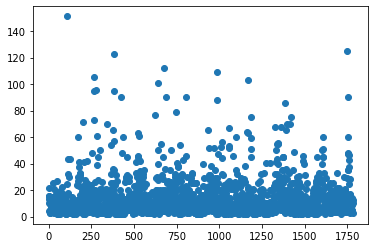

In [17]:
import matplotlib.pyplot as plt
plt.plot(audio_lengths,'o')
# plt.ylabel('some numbers')
plt.show()

In [49]:
max(audio_lengths)

151.193625

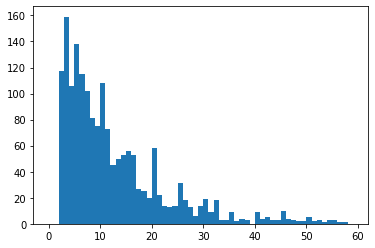

In [75]:
b[1][:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [87]:
!pwd

/home/enis/projects/nna/src/nna/exp/megan/run-2


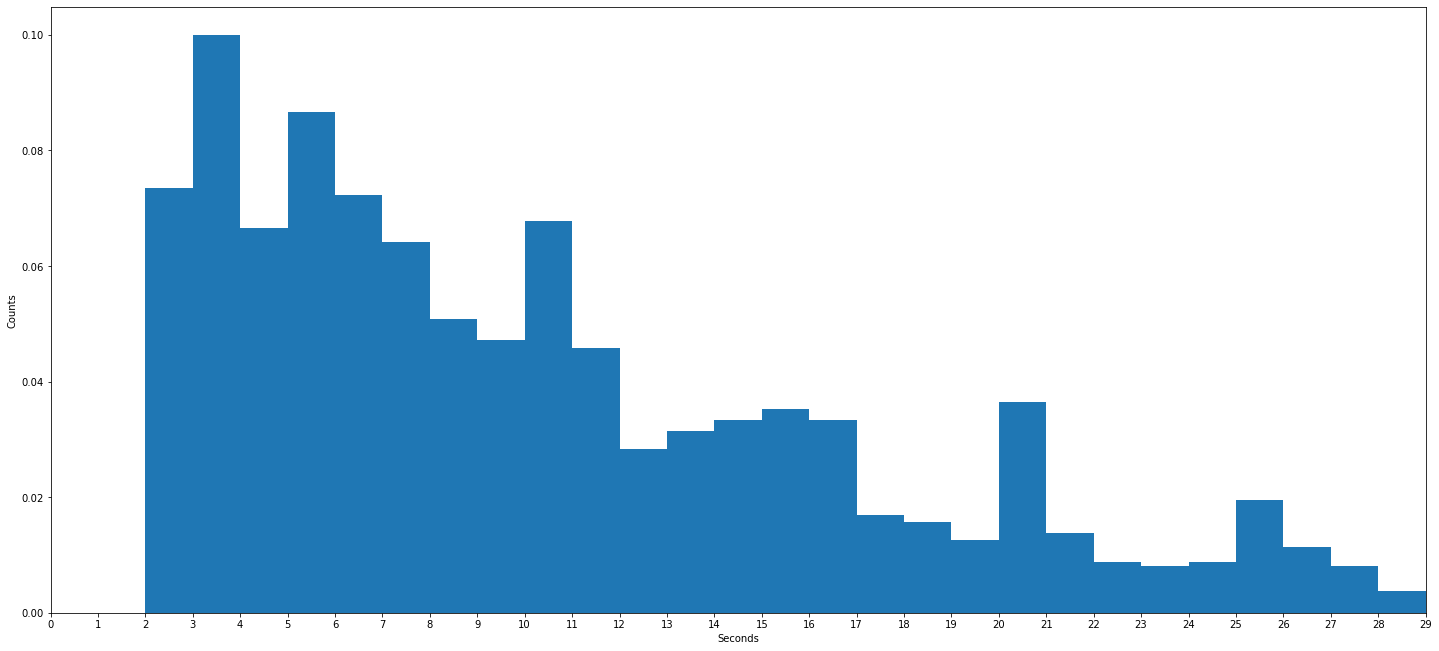

In [88]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# np.random.seed(42)
# x = np.random.normal(size=1000)
fig=plt.figure(figsize=(20,10))
# (n, bins, patches) =plt.hist(audio_lengths[audio_lengths<=20], density=False, bins=20,histtype='step')  # density=False would make counts
counts,bins=np.histogram(audio_lengths, bins=range(0,30))

bb=plt.hist(bins[:-1], bins, weights=counts,density=False)

plt.xticks(bins);
plt.ylabel('Counts')
plt.xlabel('Seconds');

plt.tight_layout()
plt.margins(x=0)
plt.subplots_adjust(top=0.90)
fig.savefig('asd.jpeg')

In [58]:
# bins

In [33]:
audio_lengths=np.array(audio_lengths)

In [91]:
max(audio_lengths)

151.193625

In [93]:
audio_lengths[audio_lengths>30].size/audio_lengths.size

0.09927089175546831

In [46]:
audio_lengths.size

1783

In [92]:
len(audio_lengths)

1783

In [71]:
for i in np.ones((2,3)):
    print(i)

[1. 1. 1.]
[1. 1. 1.]


In [25]:
sound_ins.data.shape[0]

1045414

In [95]:
c=0
for m in audio_lengths:
    if m>10 and m//10>5:
        c+=1
c

40

In [22]:
# sound_ins=next(iter(audio_dataset.items()))

In [23]:
# sound_ins[1].location_id

In [24]:
# sound_ins[1].taxo_code

In [25]:
# sound_ins[1].taxo_code
# classA = 1.1.7 #'duck-goose-swan']
# classB = 0.2.0 # other-aircraft
# 3.0.0 : 0.48, 0.26, 0.26, 46 # silence
# 2.1.0 : 0.22, 0.56, 0.22, 18 # rain
# 1.3.0 1.3.0 : 0.52, 0.4, 0.087, 161 # insect
# 1.1.8 : 0.49, 0.19, 0.32, 88 # grouse-ptarmigan

other_taxo = ['3.0.0','2.1.0','1.3.0','1.1.8']

sampleTest= []
y=[]
location_id_info = []
expected_len=10
for sound_ins in audio_dataset.values():
    if sound_ins.taxo_code in ['1.1.10','1.1.7'] + other_taxo:
        y.append(sound_ins.taxo_code)
        location_id_info.append(sound_ins.location_id)
        if sound_ins.length<10:
            tile_reps = (expected_len/(sound_ins.length)+1)
            repeated_data = np.tile(sound_ins.data,int(tile_reps))
            repeated_data = repeated_data[:expected_len*sound_ins.sr]
            sampleTest.append(repeated_data)
        else:
            sampleTest.append(sound_ins.data[:expected_len*sound_ins.sr])

len(sampleTest),len(y)

# sampleTest=np.array(sampleTest)

(832, 832)

In [26]:
313+589,(46+18+161+88)/589 


(902, 0.5314091680814941)

In [27]:
from numpy import argmax
# define input string
# define universe of possible input values
alphabet = ['1.1.10','1.1.7']
# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# integer encode input data
integer_encoded = [char_to_int.get(char,None) for char in y]
# print(integer_encoded)
# one hot encode
onehot_encoded = list()
for value in integer_encoded:
	letter = [0 for _ in range(len(alphabet))]
	if value is not None:
		letter[value] = 1
	onehot_encoded.append(letter)
# print(onehot_encoded)
# invert encoding
inverted = int_to_char[argmax(onehot_encoded[0])]
# print(inverted)
onehot_encoded=np.array(onehot_encoded)

In [28]:
X_train,X_test, X_val, y_train, y_test,y_val  = [],[],[],[],[],[]
loc_id_train=[]
loc_id_test=[]
loc_id_valid=[]

for sample,y_val_ins,loc_id in  zip(sampleTest,onehot_encoded,location_id_info):
    if loc_id in loc_per_set[0]:
        X_train.append(sample)
        y_train.append(y_val_ins)
        loc_id_train.append(loc_id)
    elif loc_id in loc_per_set[1]:
        X_test.append(sample)
        y_test.append(y_val_ins)
        loc_id_test.append(loc_id)
    elif loc_id in loc_per_set[2]:
        X_val.append(sample)
        y_val.append(y_val_ins)
        loc_id_valid.append(loc_id)
    else:
        print('error')


In [29]:
set(loc_id_train),set(loc_id_test),set(loc_id_valid)

({'11',
  '16',
  '17',
  '19',
  '20',
  '21',
  '24',
  '25',
  '29',
  '37',
  '38',
  '39',
  '44',
  '46',
  '48',
  '50'},
 {'15', '18', '22', '27', '31', '32', '33', '41', '47'},
 {'14', '30', '40', '49'})

In [30]:
len(sampleTest)

832

In [31]:
X_train,X_test,X_val=np.array(X_train),np.array(X_test),np.array(X_val)
y_train,y_test,y_val=np.array(y_train),np.array(y_test),np.array(y_val)


In [32]:
# X_train, X_test, y_train, y_test = train_test_split(
#                 sampleTest, onehot_encoded, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(
#                 X_train, y_train, test_size=0.25,random_state=42)

In [33]:
X_train,X_test,X_val=torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(),torch.from_numpy(X_val).float()
y_train,y_test,y_val=torch.from_numpy(y_train).float(),torch.from_numpy(y_test).float(),torch.from_numpy(y_val).float()


In [34]:
X_train.shape,X_test.shape,X_val.shape

(torch.Size([459, 480000]),
 torch.Size([216, 480000]),
 torch.Size([157, 480000]))

In [35]:
y_train.shape,y_test.shape,y_val.shape

(torch.Size([459, 2]), torch.Size([216, 2]), torch.Size([157, 2]))

In [36]:
# y_val[0:3]

In [37]:
# # X_train,X_test,X_val,y_train,y_test,y_val = load_raw_data('labelsbyhumanpath','sourcePath')
# X_train,X_test,X_val,y_train,y_test,y_val = mock_raw_data(4,CATEGORY_COUNT)
# X_train,X_test,X_val=torch.from_numpy(X_train).float(),torch.from_numpy(X_test).float(),torch.from_numpy(X_val).float()
# y_train,y_test,y_val=torch.from_numpy(y_train).float(),torch.from_numpy(y_test).float(),torch.from_numpy(y_val).float()

# # labelsbyhumanpath = Path('/scratch/enis/data/nna/labeling/results/')
# # with open(labelsbyhumanpath/"np_array_Ymatrix.npy", 'rb') as f:
# #     y_true = np.load(f)

# Counter(np.argmax(y_train,axis=1).tolist()),Counter(np.argmax(y_val,axis=1).tolist()),Counter(np.argmax(y_test,axis=1).tolist())


In [38]:

# X_train2=np.interp(X_train, (X_train.min(), X_train.max()), (-32768 , 32767))
# torch.from_numpy(X_train2).float()


In [39]:
# y_val

In [40]:
# smaple_index=10
# X_train[smaple_index,:],y_train[smaple_index,]


In [41]:
# X_train[0,:].shape

In [42]:
# multiply(torch.ones((1,2)),torch.ones((1,2)))

In [43]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, maxMelLen, sampling_rate):
        # sr = 44100 etc
        self.maxMelLen = maxMelLen
        self.sampling_rate = sampling_rate

    def __call__(self, sample):
        x, y = sample
        #https://github.com/PCerles/audio/blob/3803d0b27a4e13efa760227ef6c71d0f3753aa98/test/test_transforms.py#L262
        #librosa defaults
        n_fft = 2048
        hop_length = 512
        power = 2.0
        n_mels = 128
        n_mfcc = 40
        # htk is false in librosa, no setting in torchaudio -?
        # norm is 1 in librosa, no setting in torchaudio -?
        melspect_transform = torchaudio.transforms.MelSpectrogram(sample_rate=self.sampling_rate, window_fn=torch.hann_window,
                                                                  hop_length=hop_length, n_mels=n_mels, n_fft=n_fft)

    
        db_transform = torchaudio.transforms.AmplitudeToDB("power", 80.)
        mel = melspect_transform(x.reshape(-1))
        an_x = db_transform(mel)
        #librosa version
#         mel = librosa.feature.melspectrogram(y=x.reshape(-1),
#                                              sr=self.sampling_rate)
#         an_x = librosa.power_to_db(mel, ref=np.max)
#         an_x = an_x.astype("float32")
#         y = y.astype('float32')
#         print(an_x.shape)
        an_x = an_x[:, :self.maxMelLen]
        # 2-d conv
#         x = an_x.reshape(1, *an_x.shape[:])
        # 1-d conv
        x = an_x.reshape(1, an_x.shape[0]*an_x.shape[1])

        
        return x,y

# #test
# maxMelLen_test = 850
# SAMPLING_RATE_test = 48000
# sample_len_seconds = 10
# # to_tensor works on single sample
# sample_count = 1
# xx_test = torch.ones((sample_count,SAMPLING_RATE_test*sample_len_seconds))
# y_values = torch.ones(sample_count)
# 
# toTensor = ToTensor(maxMelLen_test,SAMPLING_RATE_test)
# x_out,y_out=toTensor((xx_test,y_values))
# x_out.shape,y_out.shape

In [44]:
# X_train,X_test,X_val,y_train,y_test,y_val
X_train[:].shape

torch.Size([459, 480000])

In [45]:
# toTensor = ToTensor(maxMelLen_test,SAMPLING_RATE_test)
# x_out2,y_out=toTensor((X_train[1:2,:],y_train))
# x_out.shape,y_out.shape

In [46]:
# torch.mean(x_out[0]),torch.mean(x_out2[0])
# y_train

In [47]:
# X_train,y_train

In [48]:

# pitch = augmentations.pitch_shift_n_stepsClass(
#     runconfigs.SAMPLING_RATE, config['pitch_shift_n_steps'])
# noise = augmentations.addNoiseClass(config['noise_factor'])
# strech = augmentations.time_stretchClass(runconfigs.SAMPLING_RATE*runconfigs.EXCERPT_LENGTH,
#                                             config['time_stretch_factor'],
#                                             isRandom=True)
# shift = augmentations.shiftClass(config['roll_rate'], isRandom=True)
maxMelLen = 938 # old 850
# toTensor = augmentations.ToTensor(maxMelLen,runconfigs.SAMPLING_RATE)
toTensor = ToTensor(maxMelLen,runconfigs.SAMPLING_RATE)

In [49]:
from ignite.metrics import EpochMetric


def roc_auc_perClass_compute_fn(y_preds, y_targets):
    try:
        from sklearn.metrics import roc_auc_score
    except ImportError:
        raise RuntimeError(
            "This contrib module requires sklearn to be installed.")

    y_true = y_targets.numpy()
    y_pred = y_preds.numpy()
#     print(y_pred,y_true)
#     res = []
#     for y_true_perClass_Index in y_true.shape[1]:
#         res.append(
#             roc_auc_score(y_true[:, y_true_perClass_Index],
#                           y_pred[:, y_true_perClass_Index]))
    res = roc_auc_score(y_true, y_pred, average=None)
    return res


#[docs]
class ROC_AUC_perClass(EpochMetric):
    """Computes Area Under the Receiver Operating Characteristic Curve (ROC AUC)
  accumulating predictions and the ground-truth during an epoch and applying
  `sklearn.metrics.roc_auc_score <http://scikit-learn.org/stable/modules/generated/
  sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score>`_ .

  Args:
      output_transform (callable, optional): a callable that is used to transform the
          :class:`~ignite.engine.engine.Engine`'s ``process_function``'s output into the
          form expected by the metric. This can be useful if, for example, you have a multi-output model and
          you want to compute the metric with respect to one of the outputs.
      check_compute_fn (bool): Optional default False. If True, `roc_curve
          <http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#
          sklearn.metrics.roc_auc_score>`_ is run on the first batch of data to ensure there are
          no issues. User will be warned in case there are any issues computing the function.

  ROC_AUC expects y to be comprised of 0's and 1's. y_pred must either be probability estimates or confidence
  values. To apply an activation to y_pred, use output_transform as shown below:

  .. code-block:: python

      def activated_output_transform(output):
          y_pred, y = output
          y_pred = torch.sigmoid(y_pred)
          return y_pred, y

      roc_auc = ROC_AUC(activated_output_transform)

  """
    def __init__(self,
                 output_transform=lambda x: x,
                 check_compute_fn: bool = False):
#         print(output_transform)
        super(ROC_AUC_perClass,
              self).__init__(roc_auc_perClass_compute_fn,
                             output_transform=output_transform,
                             check_compute_fn=check_compute_fn)


In [50]:

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
  Utility function for computing output of convolutions
  takes a tuple of (h,w) and returns a tuple of (h,w)
  """
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor(((h_w[0] + (2 * pad) - (dilation *
                                      (kernel_size[0] - 1)) - 1) / stride) + 1)
    w = floor(((h_w[1] + (2 * pad) - (dilation *
                                      (kernel_size[1] - 1)) - 1) / stride) + 1)
    return h, w

# mel.shape,an_x.shape,X_train.shape
class testModel(nn.Module):
    '''A simple model for testing by overfitting.
    '''
    def __init__(self, out_channels, h_w, kernel_size, FLAT=False,output_shape=(10,)):
        # h_w: height will be always one since we use 1d convolution 
        super(testModel, self).__init__()
        self.out_channels = out_channels
        #### CONV
        self.conv1 = nn.Conv1d(in_channels=1, # depth of image == depth of filters
                               out_channels=self.out_channels, # number of filters 
                               kernel_size=kernel_size, # size of the filters/kernels
                               padding=1)

        self.conv1_shape = conv_output_shape(h_w, kernel_size=kernel_size, stride=1, pad=1, dilation=1)
        # conv is 1d
        self.conv1_shape = (1,self.conv1_shape[1])
        
        self.fc1 = nn.Linear(self.out_channels * self.conv1_shape[0] *self.conv1_shape[1], 64)  # 100

        self.fc2 = nn.Linear(64,output_shape[0])
        
    def forward(self, x):
#         x = x.reshape(1,)
#         print(x.shape) #  50,1,108800 (850*128)
        x = F.relu(self.conv1(x))
#         x = self.pool(x)
        # x = self.drop(x)
#         print(x.shape)# 58, 2, 108801
#         print(self.conv1_shape)
#         print(x.shape)
        x = x.view(-1, self.out_channels * self.conv1_shape[0] *self.conv1_shape[1])
        # batch_norm is missing
        x = F.relu((self.fc1(x)))
        x = (self.fc2(x))

#         x = self.drop(x)

#         x = self.fc4(x)
#         x = torch.sigmoid(x)
#                 x = F.log_softmax(x,dim=1)
        return x

# test
# input_shape=(1,(938*128))
# output_shape=(10,)
# testModel_ins=adam(out_channels=2,h_w=input_shape,kernel_size=2,output_shape=output_shape)
# # a.conv1.weight
# a_out=testModel_ins(torch.ones((3,1,input_shape[1])))

# a_out_correct=torch.zeros(a_out.shape)
# a_out_correct[0][:]=1
# a_out_correct
# a_out.detach().numpy()

# torch.exp(a_out),a_out

In [51]:

# for y_true_perClass_Index in a_out_correct.shape[1]:
#     print(y_true_perClass_Index)

In [52]:
# from ignite.contrib.metrics import ROC_AUC
# from nna.exp.metrics import ROC_AUC_perClass
def activated_output_transform(output):
    y_pred, y = output
#     y_pred = torch.exp(y_pred)
    return y_pred, y

In [53]:
# asd=ROC_AUC_perClass(activated_output_transform)
# asd.update((a_out,a_out_correct))
# asd.compute()

In [54]:

transformCompose = transforms.Compose([
#     pitch,
#     strech,
#     shift,
#     noise,
    toTensor,
])


sound_datasets = {
    phase: runutils.audioDataset(XY[0], XY[1], transform=transformCompose)
    for phase, XY in
    zip(['train', 'val', 'test'],
        [[X_train, y_train], [X_val, y_val], [X_test, y_test]])
}

dataloaders = {
    x: torch.utils.data.DataLoader(sound_datasets[x], **params)
    for x in ['train', 'val', 'test']
}

# this will change
h_w = [128, 938]
kernel_size = (3, 3)
# if config['CNNLayer_count'] == 1:
#     model = modelArchs.NetCNN1(config['CNN_filters_1'], h_w,
#                                 kernel_size).float().to(device)

# if config['CNNLayer_count'] == 2:
#     model = modelArchs.NetCNN2(config['CNN_filters_1'], config.CNN_filters_2,
#                                 h_w, kernel_size,
#                                 kernel_size).float().to(device)

#simpler model

output_shape=(CATEGORY_COUNT,)
model = testModel(out_channels=2,h_w=(1,h_w[0]*h_w[1]),kernel_size=kernel_size[0]*kernel_size[0],output_shape=output_shape)
model.float().to(device)

# device is defined before

model.float().to(device)  # Move model before creating optimizer
optimizer = torch.optim.AdamW(model.parameters(),
#                                 weight_decay=config['weight_decay'],
                             )



criterion = nn.BCEWithLogitsLoss()
# statHistory={'valLoss':[],'trainLoss':[],'trainAUC':[],'valAUC':[]}

metrics = {
    'loss': Loss(criterion),  # 'accuracy': Accuracy(),
#     'ROC_AUC': ROC_AUC(runutils.activated_output_transform),
    'ROC_AUC': ROC_AUC_perClass(activated_output_transform),

}


In [55]:
model

testModel(
  (conv1): Conv1d(1, 2, kernel_size=(9,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=240116, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [56]:
model.conv1.weight

Parameter containing:
tensor([[[ 0.2548,  0.2767, -0.0781,  0.3062, -0.0730,  0.0673, -0.1623,
           0.1958,  0.2938]],

        [[-0.2445,  0.2897,  0.0624,  0.2463,  0.0451,  0.1607, -0.0471,
           0.2570,  0.0493]]], device='cuda:1', requires_grad=True)

In [57]:
model.conv1

Conv1d(1, 2, kernel_size=(9,), stride=(1,), padding=(1,))

In [58]:
model.fc1.weight

Parameter containing:
tensor([[-9.4025e-04, -2.3932e-04, -8.2887e-04,  ..., -1.1343e-03,
          1.7488e-04, -2.2776e-05],
        [-1.3098e-03, -1.8676e-03, -6.3240e-04,  ...,  2.8130e-04,
          1.6656e-03, -4.6616e-04],
        [-1.9303e-03, -7.0706e-04,  1.8977e-03,  ..., -8.3026e-04,
          2.5134e-04, -7.0575e-04],
        ...,
        [-2.0255e-03, -1.0723e-03,  5.2723e-04,  ..., -3.9869e-04,
          1.9361e-03, -1.1633e-03],
        [ 4.8982e-04, -1.2842e-03,  9.8855e-04,  ...,  7.6381e-04,
         -8.6123e-04,  6.6515e-04],
        [ 1.8723e-04,  8.9811e-04, -1.4482e-03,  ..., -5.3925e-04,
          5.5443e-04,  1.4453e-03]], device='cuda:1', requires_grad=True)

In [59]:
# test

In [ ]:
print('ready ?')
runutils.run(model, dataloaders, optimizer, criterion, metrics, device,config, runconfigs.PROJECT_NAME)


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: enisberk (use `wandb login --relogin` to force relogin)


ready ?


wandb: wandb version 0.10.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


2021-01-26 09:43:06,520 Trainer INFO: Engine run starting with max_epochs=2000.
/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/scratch/enis/conda/envs/soundenv3/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, retu

train loss 1685.1240657232945
val loss 1209.0644663428045
validation roc auc [0.65373134 0.61582569] 1
train roc auc [0.49208553 0.5599308 ] 1


2021-01-26 09:44:23,664 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:44:44,870 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:44:44,873 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:44:44,883 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:44:51,804 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:44:52,122 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 2 < 16; dropping {'lr/group_0': 0.001}.
2021-01-26 09:44:52,137 Trainer INFO: Epoch[2] Complete. Time taken: 00:00:52


train loss 1082.7270795036766
val loss 1865.0308394705414
validation roc auc [0.35903814 0.40711009] 2
train roc auc [0.51305193 0.46268226] 2


2021-01-26 09:45:13,037 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:45:34,504 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:45:34,507 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:45:34,508 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:45:41,940 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:45:42,260 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 3 < 24; dropping {'lr/group_0': 0.001}.
2021-01-26 09:45:42,278 Trainer INFO: Epoch[3] Complete. Time taken: 00:00:50


train loss 554.012551301445
val loss 470.3751634731414
validation roc auc [0.65936982 0.47610856] 3
train roc auc [0.49611219 0.56054864] 3


2021-01-26 09:46:04,108 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:46:24,683 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:46:24,686 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:46:24,687 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:46:32,501 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 09:46:32,811 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 4 < 32; dropping {'lr/group_0': 0.001}.
2021-01-26 09:46:32,824 Trainer INFO: Epoch[4] Complete. Time taken: 00:00:51


train loss 141.12315119325726
val loss 265.08667769705414
validation roc auc [0.45887231 0.46368502] 4
train roc auc [0.60285833 0.51569322] 4


2021-01-26 09:46:53,611 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:47:16,586 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-01-26 09:47:16,588 Train Evaluator INFO: Engine run complete. Time taken: 00:00:23
2021-01-26 09:47:16,589 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:47:24,284 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 09:47:24,589 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 5 < 40; dropping {'lr/group_0': 0.001}.
2021-01-26 09:47:24,599 Trainer INFO: Epoch[5] Complete. Time taken: 00:00:52


train loss 66.10263043447257
val loss 96.27349037121816
validation roc auc [0.44825871 0.7360474 ] 5
train roc auc [0.61439283 0.63423676] 5


2021-01-26 09:47:48,969 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:48:11,158 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 09:48:11,160 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 09:48:11,161 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:48:18,436 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:48:18,759 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 6 < 48; dropping {'lr/group_0': 0.001}.
2021-01-26 09:48:18,771 Trainer INFO: Epoch[6] Complete. Time taken: 00:00:54


train loss 81.80038668231506
val loss 153.37002378816058
validation roc auc [0.54311774 0.46406728] 6
train roc auc [0.62577855 0.55490568] 6


2021-01-26 09:48:42,077 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:49:03,238 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:49:03,240 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:49:03,241 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:49:09,556 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 09:49:09,886 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 7 < 56; dropping {'lr/group_0': 0.001}.
2021-01-26 09:49:09,907 Trainer INFO: Epoch[7] Complete. Time taken: 00:00:51


train loss 52.996103344919376
val loss 51.61265967302262
validation roc auc [0.56467662 0.75382263] 7
train roc auc [0.60748007 0.65207183] 7


2021-01-26 09:49:32,301 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:49:53,552 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:49:53,555 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:49:53,556 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:50:00,946 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:50:01,221 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 8 < 64; dropping {'lr/group_0': 0.001}.
2021-01-26 09:50:01,232 Trainer INFO: Epoch[8] Complete. Time taken: 00:00:51


train loss 39.96793232504319
val loss 90.8324608286475
validation roc auc [0.45190713 0.48853211] 8
train roc auc [0.67382076 0.65450202] 8


2021-01-26 09:50:21,715 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:50:42,968 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:50:42,970 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:50:42,972 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:50:50,996 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 09:50:51,335 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 9 < 72; dropping {'lr/group_0': 0.001}.
2021-01-26 09:50:51,344 Trainer INFO: Epoch[9] Complete. Time taken: 00:00:50


train loss 51.808635337679995
val loss 102.03630547007178
validation roc auc [0.45008292 0.48413609] 9
train roc auc [0.67233308 0.64210396] 9


2021-01-26 09:51:12,059 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:51:34,718 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-01-26 09:51:34,720 Train Evaluator INFO: Engine run complete. Time taken: 00:00:23
2021-01-26 09:51:34,721 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:51:41,341 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:51:41,686 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 10 < 80; dropping {'lr/group_0': 0.001}.
2021-01-26 09:51:41,694 Trainer INFO: Epoch[10] Complete. Time taken: 00:00:50


train loss 18.676960232470808
val loss 23.769011758694983
validation roc auc [0.44212272 0.75344037] 10
train roc auc [0.67106359 0.64675838] 10


2021-01-26 09:52:03,915 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:52:26,282 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 09:52:26,284 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 09:52:26,286 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:52:36,238 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:10
2021-01-26 09:52:36,512 Val Evaluator INFO: Engine run complete. Time taken: 00:00:10
wandb: WARNING Step must only increase in log calls.  Step 11 < 88; dropping {'lr/group_0': 0.001}.
2021-01-26 09:52:36,519 Trainer INFO: Epoch[11] Complete. Time taken: 00:00:55


train loss 182.57796117578977
val loss 173.0313544789697
validation roc auc [0.58855721 0.53306575] 11
train roc auc [0.56711429 0.66595271] 11


2021-01-26 09:52:56,757 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:53:20,510 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:24
2021-01-26 09:53:20,513 Train Evaluator INFO: Engine run complete. Time taken: 00:00:24
2021-01-26 09:53:20,515 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:53:28,156 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 09:53:28,432 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 12 < 96; dropping {'lr/group_0': 0.001}.
2021-01-26 09:53:28,447 Trainer INFO: Epoch[12] Complete. Time taken: 00:00:52


train loss 128.91522113741874
val loss 98.83933734286363
validation roc auc [0.55323383 0.74560398] 12
train roc auc [0.62121633 0.63357772] 12


2021-01-26 09:53:48,773 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:54:10,077 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:54:10,081 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:54:10,082 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:54:17,128 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:54:17,442 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 13 < 104; dropping {'lr/group_0': 0.001}.
2021-01-26 09:54:17,453 Trainer INFO: Epoch[13] Complete. Time taken: 00:00:49


train loss 195.10423597946667
val loss 154.37532325307276
validation roc auc [0.59568823 0.67507645] 13
train roc auc [0.56470425 0.66059807] 13


2021-01-26 09:54:41,934 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:55:03,925 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 09:55:03,927 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 09:55:03,929 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:55:11,447 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 09:55:11,751 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 14 < 112; dropping {'lr/group_0': 0.001}.
2021-01-26 09:55:11,760 Trainer INFO: Epoch[14] Complete. Time taken: 00:00:54


train loss 69.14773511367166
val loss 104.62772102112983
validation roc auc [0.43880597 0.61219419] 14
train roc auc [0.63343516 0.65827086] 14


2021-01-26 09:55:33,234 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:55:53,431 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 09:55:53,434 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 09:55:53,435 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:55:59,852 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 09:55:59,856 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 15 < 120; dropping {'lr/group_0': 0.001}.
2021-01-26 09:55:59,866 Trainer INFO: Epoch[15] Complete. Time taken: 00:00:48


train loss 120.01176635476239
val loss 223.54343195629727
validation roc auc [0.44593698 0.46693425] 15
train roc auc [0.64295632 0.53323997] 15


2021-01-26 09:56:23,672 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:56:45,293 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 09:56:45,296 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 09:56:45,298 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:56:52,819 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 09:56:52,822 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 16 < 128; dropping {'lr/group_0': 0.001}.
2021-01-26 09:56:52,832 Trainer INFO: Epoch[16] Complete. Time taken: 00:00:53


train loss 32.27186282787448
val loss 73.17556646067625
validation roc auc [0.46898839 0.51509939] 16
train roc auc [0.68266751 0.66142186] 16


2021-01-26 09:57:15,326 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:57:37,351 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 09:57:37,353 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 09:57:37,354 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:57:43,997 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:57:44,316 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 17 < 136; dropping {'lr/group_0': 0.001}.
2021-01-26 09:57:44,331 Trainer INFO: Epoch[17] Complete. Time taken: 00:00:51


train loss 64.23298576870255
val loss 105.03784029043405
validation roc auc [0.46334992 0.57807722] 17
train roc auc [0.66828659 0.6813988 ] 17


2021-01-26 09:58:08,053 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:58:29,418 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 09:58:29,421 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 09:58:29,422 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:58:36,636 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:58:36,956 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 18 < 144; dropping {'lr/group_0': 0.001}.
2021-01-26 09:58:36,975 Trainer INFO: Epoch[18] Complete. Time taken: 00:00:53


train loss 39.92912025700987
val loss 76.09412957452665
validation roc auc [0.48358209 0.56479358] 18
train roc auc [0.69107788 0.68485872] 18


2021-01-26 09:58:58,127 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:59:18,231 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 09:59:18,234 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 09:59:18,235 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 09:59:25,029 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 09:59:25,032 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 19 < 152; dropping {'lr/group_0': 0.001}.
2021-01-26 09:59:25,040 Trainer INFO: Epoch[19] Complete. Time taken: 00:00:48


train loss 140.59166463216147
val loss 236.93753304451135
validation roc auc [0.45721393 0.4860474 ] 19
train roc auc [0.62603642 0.62356866] 19


2021-01-26 09:59:43,799 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:00:03,508 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:00:03,511 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:00:03,512 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:00:10,837 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:00:10,839 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 20 < 160; dropping {'lr/group_0': 0.001}.
2021-01-26 10:00:10,847 Trainer INFO: Epoch[20] Complete. Time taken: 00:00:46


train loss 147.6485434305694
val loss 256.5607793528563
validation roc auc [0.4628524  0.47457951] 20
train roc auc [0.63438727 0.57545926] 20


2021-01-26 10:00:32,560 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:00:53,352 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:00:53,356 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:00:53,357 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:01:00,256 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:01:00,612 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 21 < 168; dropping {'lr/group_0': 0.001}.
2021-01-26 10:01:00,620 Trainer INFO: Epoch[21] Complete. Time taken: 00:00:50


train loss 33.5142979175177
val loss 45.78952456431784
validation roc auc [0.54626866 0.76624618] 21
train roc auc [0.66995279 0.68675344] 21


2021-01-26 10:01:24,475 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:01:44,956 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:01:44,959 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:01:44,960 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:01:51,164 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:01:51,500 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 22 < 176; dropping {'lr/group_0': 0.001}.
2021-01-26 10:01:51,512 Trainer INFO: Epoch[22] Complete. Time taken: 00:00:51


train loss 14.860989880198227
val loss 24.16794790280093
validation roc auc [0.49054726 0.7742737 ] 22
train roc auc [0.69806998 0.67542631] 22


2021-01-26 10:02:14,002 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:02:34,116 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:02:34,118 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:02:34,119 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:02:42,027 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:02:42,324 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 23 < 184; dropping {'lr/group_0': 0.001}.
2021-01-26 10:02:42,333 Trainer INFO: Epoch[23] Complete. Time taken: 00:00:51


train loss 29.545853492221543
val loss 45.647716157755276
validation roc auc [0.48457711 0.7675841 ] 23
train roc auc [0.70208672 0.67983359] 23


2021-01-26 10:03:04,610 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:03:25,651 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:03:25,653 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:03:25,655 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:03:33,101 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:03:33,471 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 24 < 192; dropping {'lr/group_0': 0.001}.
2021-01-26 10:03:33,496 Trainer INFO: Epoch[24] Complete. Time taken: 00:00:51


train loss 8.792616327863373
val loss 19.832272936584083
validation roc auc [0.48175788 0.75076453] 24
train roc auc [0.70458603 0.68625916] 24


2021-01-26 10:03:55,292 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:04:14,329 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:19
2021-01-26 10:04:14,331 Train Evaluator INFO: Engine run complete. Time taken: 00:00:19
2021-01-26 10:04:14,332 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:04:20,149 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:04:20,539 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 25 < 200; dropping {'lr/group_0': 0.001}.
2021-01-26 10:04:20,550 Trainer INFO: Epoch[25] Complete. Time taken: 00:00:47


train loss 55.560586268605746
val loss 45.080204277281545
validation roc auc [0.53499171 0.75286697] 25
train roc auc [0.68215178 0.65907406] 25


2021-01-26 10:04:42,936 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:05:03,400 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:05:03,404 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:05:03,406 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:05:11,300 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:05:11,588 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 26 < 208; dropping {'lr/group_0': 0.001}.
2021-01-26 10:05:11,606 Trainer INFO: Epoch[26] Complete. Time taken: 00:00:51


train loss 47.63126764733807
val loss 46.71753175091592
validation roc auc [0.57810945 0.75420489] 26
train roc auc [0.66870314 0.69581514] 26


2021-01-26 10:05:33,536 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:05:55,200 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:05:55,203 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:05:55,204 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:06:02,306 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:06:02,635 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 27 < 216; dropping {'lr/group_0': 0.001}.
2021-01-26 10:06:02,652 Trainer INFO: Epoch[27] Complete. Time taken: 00:00:51


train loss 6.669866115179457
val loss 12.08032680924531
validation roc auc [0.48043118 0.75764526] 27
train roc auc [0.72196215 0.68737128] 27


2021-01-26 10:06:24,310 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:06:44,738 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:06:44,741 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:06:44,742 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:06:51,875 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:06:51,879 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 28 < 224; dropping {'lr/group_0': 0.001}.
2021-01-26 10:06:51,888 Trainer INFO: Epoch[28] Complete. Time taken: 00:00:49


train loss 57.34715929218367
val loss 95.24876170553219
validation roc auc [0.45887231 0.54816514] 28
train roc auc [0.70523069 0.72283549] 28


2021-01-26 10:07:14,189 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:07:34,388 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:07:34,391 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:07:34,392 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:07:41,243 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:07:41,246 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 29 < 232; dropping {'lr/group_0': 0.001}.
2021-01-26 10:07:41,255 Trainer INFO: Epoch[29] Complete. Time taken: 00:00:49


train loss 33.45061052442895
val loss 52.602929084923616
validation roc auc [0.46119403 0.67851682] 29
train roc auc [0.7267029  0.72024055] 29


2021-01-26 10:08:01,630 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:08:23,211 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:08:23,214 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:08:23,215 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:08:29,514 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:08:29,517 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 30 < 240; dropping {'lr/group_0': 0.001}.
2021-01-26 10:08:29,525 Trainer INFO: Epoch[30] Complete. Time taken: 00:00:48


train loss 16.584534697023614
val loss 22.550909929214768
validation roc auc [0.47147595 0.71616972] 30
train roc auc [0.73695799 0.71743966] 30


2021-01-26 10:08:49,949 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:09:09,748 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:09:09,750 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:09:09,751 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:09:16,451 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:09:16,453 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 31 < 248; dropping {'lr/group_0': 0.001}.
2021-01-26 10:09:16,461 Trainer INFO: Epoch[31] Complete. Time taken: 00:00:47


train loss 13.922211009173092
val loss 16.204874804065486
validation roc auc [0.47097844 0.73853211] 31
train roc auc [0.74171857 0.710561  ] 31


2021-01-26 10:09:38,558 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:09:59,631 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:09:59,634 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:09:59,635 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:10:07,500 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:10:07,502 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 32 < 256; dropping {'lr/group_0': 0.001}.
2021-01-26 10:10:07,510 Trainer INFO: Epoch[32] Complete. Time taken: 00:00:51


train loss 2.2534444332122803
val loss 4.490767562465304
validation roc auc [0.46583748 0.74426606] 32
train roc auc [0.75481017 0.70990197] 32


2021-01-26 10:10:30,533 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:10:51,129 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:10:51,132 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:10:51,133 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:10:58,355 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:10:58,358 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 33 < 264; dropping {'lr/group_0': 0.001}.
2021-01-26 10:10:58,365 Trainer INFO: Epoch[33] Complete. Time taken: 00:00:51


train loss 16.206075190458943
val loss 24.375899053682947
validation roc auc [0.45754561 0.72381498] 33
train roc auc [0.75676399 0.73321526] 33


2021-01-26 10:11:18,260 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:11:38,517 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:11:38,526 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:11:38,528 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:11:46,514 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:11:46,518 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 34 < 272; dropping {'lr/group_0': 0.001}.
2021-01-26 10:11:46,534 Trainer INFO: Epoch[34] Complete. Time taken: 00:00:48


train loss 8.832844188789917
val loss 14.090006214797876
validation roc auc [0.46235489 0.71005352] 34
train roc auc [0.76665212 0.74029986] 34


2021-01-26 10:12:08,998 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:12:28,988 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:12:28,991 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:12:28,992 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:12:36,040 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:12:36,043 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 35 < 280; dropping {'lr/group_0': 0.001}.
2021-01-26 10:12:36,050 Trainer INFO: Epoch[35] Complete. Time taken: 00:00:50


train loss 6.238651885446121
val loss 10.497521667723444
validation roc auc [0.46600332 0.71999235] 35
train roc auc [0.77877177 0.74816706] 35


2021-01-26 10:12:59,192 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:13:19,864 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:13:19,870 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:13:19,872 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:13:26,008 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:13:26,011 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 36 < 288; dropping {'lr/group_0': 0.001}.
2021-01-26 10:13:26,019 Trainer INFO: Epoch[36] Complete. Time taken: 00:00:50


train loss 6.8450533112669305
val loss 12.512118424579596
validation roc auc [0.47131012 0.71961009] 36
train roc auc [0.78747967 0.75928824] 36


2021-01-26 10:13:48,156 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:14:10,229 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:14:10,233 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:14:10,235 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:14:18,574 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:14:18,577 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 37 < 296; dropping {'lr/group_0': 0.001}.
2021-01-26 10:14:18,586 Trainer INFO: Epoch[37] Complete. Time taken: 00:00:53


train loss 12.73695004947305
val loss 21.43750773873299
validation roc auc [0.47313433 0.70470183] 37
train roc auc [0.79666363 0.77494028] 37


2021-01-26 10:14:42,314 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:15:04,221 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:15:04,224 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:15:04,225 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:15:11,091 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:15:11,094 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 38 < 304; dropping {'lr/group_0': 0.001}.
2021-01-26 10:15:11,101 Trainer INFO: Epoch[38] Complete. Time taken: 00:00:53


train loss 2.796477156916475
val loss 6.855569219892951
validation roc auc [0.4681592  0.72993119] 38
train roc auc [0.79662395 0.7646017 ] 38


2021-01-26 10:15:33,661 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:15:55,159 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:15:55,162 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:15:55,163 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:16:02,133 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:16:02,472 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 39 < 312; dropping {'lr/group_0': 0.001}.
2021-01-26 10:16:02,481 Trainer INFO: Epoch[39] Complete. Time taken: 00:00:51


train loss 39.28589312235514
val loss 32.067377272684865
validation roc auc [0.54875622 0.73451835] 39
train roc auc [0.75137859 0.74969108] 39


2021-01-26 10:16:25,153 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:16:45,482 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:16:45,486 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:16:45,488 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:16:52,998 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:16:53,000 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 40 < 320; dropping {'lr/group_0': 0.001}.
2021-01-26 10:16:53,008 Trainer INFO: Epoch[40] Complete. Time taken: 00:00:51


train loss 21.467829976466227
val loss 19.077892789415493
validation roc auc [0.4708126  0.72343272] 40
train roc auc [0.78650772 0.76703188] 40


2021-01-26 10:17:15,221 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:17:35,572 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:17:35,575 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:17:35,577 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:17:43,510 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:17:43,513 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 41 < 328; dropping {'lr/group_0': 0.001}.
2021-01-26 10:17:43,520 Trainer INFO: Epoch[41] Complete. Time taken: 00:00:51


train loss 1.3626283840935733
val loss 3.6126864563887287
validation roc auc [0.45671642 0.71731651] 41
train roc auc [0.80469711 0.780748  ] 41


2021-01-26 10:18:03,961 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:18:23,990 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:18:23,992 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:18:23,994 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:18:30,371 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:18:30,374 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 42 < 336; dropping {'lr/group_0': 0.001}.
2021-01-26 10:18:30,381 Trainer INFO: Epoch[42] Complete. Time taken: 00:00:47


train loss 9.905277206487385
val loss 17.713462185707822
validation roc auc [0.46318408 0.58256881] 42
train roc auc [0.81483318 0.82115496] 42


2021-01-26 10:18:51,335 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:19:10,326 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:19
2021-01-26 10:19:10,330 Train Evaluator INFO: Engine run complete. Time taken: 00:00:19
2021-01-26 10:19:10,332 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:19:17,614 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:19:17,617 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 43 < 344; dropping {'lr/group_0': 0.001}.
2021-01-26 10:19:17,626 Trainer INFO: Epoch[43] Complete. Time taken: 00:00:47


train loss 24.714708789501316
val loss 41.882636853843735
validation roc auc [0.44859038 0.51930428] 43
train roc auc [0.7811719  0.82791004] 43


2021-01-26 10:19:37,302 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:19:58,443 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:19:58,447 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:19:58,449 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:20:04,690 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:20:04,693 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 44 < 352; dropping {'lr/group_0': 0.001}.
2021-01-26 10:20:04,702 Trainer INFO: Epoch[44] Complete. Time taken: 00:00:47


train loss 4.021565711332692
val loss 10.415516312714596
validation roc auc [0.45655058 0.58906728] 44
train roc auc [0.8215575  0.83252327] 44


2021-01-26 10:20:26,984 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:20:47,181 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:20
2021-01-26 10:20:47,185 Train Evaluator INFO: Engine run complete. Time taken: 00:00:20
2021-01-26 10:20:47,187 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:20:54,017 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:20:54,019 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 45 < 360; dropping {'lr/group_0': 0.001}.
2021-01-26 10:20:54,028 Trainer INFO: Epoch[45] Complete. Time taken: 00:00:49


train loss 7.924403746403381
val loss 9.728522489025334
validation roc auc [0.45737977 0.71769878] 45
train roc auc [0.82627841 0.81250515] 45


2021-01-26 10:21:15,485 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:21:37,429 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:21:37,431 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:21:37,432 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:21:44,861 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:21:44,864 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 46 < 368; dropping {'lr/group_0': 0.001}.
2021-01-26 10:21:44,871 Trainer INFO: Epoch[46] Complete. Time taken: 00:00:51


train loss 0.9199562342857743
val loss 2.8247921603500465
validation roc auc [0.45804312 0.69935015] 46
train roc auc [0.83332011 0.83404729] 46


2021-01-26 10:22:07,966 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:22:30,579 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-01-26 10:22:30,582 Train Evaluator INFO: Engine run complete. Time taken: 00:00:23
2021-01-26 10:22:30,583 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:22:37,493 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:22:37,497 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 47 < 376; dropping {'lr/group_0': 0.001}.
2021-01-26 10:22:37,513 Trainer INFO: Epoch[47] Complete. Time taken: 00:00:53


train loss 6.627474718363976
val loss 11.353757074684095
validation roc auc [0.45273632 0.59461009] 47
train roc auc [0.83385568 0.85859626] 47


2021-01-26 10:22:58,330 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:23:18,908 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:23:18,911 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:23:18,913 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:23:26,572 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:23:26,575 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 48 < 384; dropping {'lr/group_0': 0.001}.
2021-01-26 10:23:26,582 Trainer INFO: Epoch[48] Complete. Time taken: 00:00:49


train loss 5.090356581091621
val loss 9.634593921102535
validation roc auc [0.45240464 0.56995413] 48
train roc auc [0.8411354  0.86938792] 48


2021-01-26 10:23:46,625 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:24:09,608 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-01-26 10:24:09,611 Train Evaluator INFO: Engine run complete. Time taken: 00:00:23
2021-01-26 10:24:09,612 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:24:18,749 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:09
2021-01-26 10:24:18,751 Val Evaluator INFO: Engine run complete. Time taken: 00:00:09
wandb: WARNING Step must only increase in log calls.  Step 49 < 392; dropping {'lr/group_0': 0.001}.
2021-01-26 10:24:18,759 Trainer INFO: Epoch[49] Complete. Time taken: 00:00:52


train loss 5.003654156894726
val loss 7.329165422233047
validation roc auc [0.45572139 0.71636086] 49
train roc auc [0.85329472 0.85000824] 49


2021-01-26 10:24:41,434 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:25:00,611 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:19
2021-01-26 10:25:00,614 Train Evaluator INFO: Engine run complete. Time taken: 00:00:19
2021-01-26 10:25:00,615 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:25:07,880 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:25:07,883 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 50 < 400; dropping {'lr/group_0': 0.001}.
2021-01-26 10:25:07,906 Trainer INFO: Epoch[50] Complete. Time taken: 00:00:49


train loss 12.355000435656711
val loss 11.412496906936548
validation roc auc [0.46484245 0.67775229] 50
train roc auc [0.86035625 0.87643134] 50


2021-01-26 10:25:29,379 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:25:52,247 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:23
2021-01-26 10:25:52,250 Train Evaluator INFO: Engine run complete. Time taken: 00:00:23
2021-01-26 10:25:52,251 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:25:58,511 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:06
2021-01-26 10:25:58,514 Val Evaluator INFO: Engine run complete. Time taken: 00:00:06
wandb: WARNING Step must only increase in log calls.  Step 51 < 408; dropping {'lr/group_0': 0.001}.
2021-01-26 10:25:58,524 Trainer INFO: Epoch[51] Complete. Time taken: 00:00:51


train loss 2.531456857984622
val loss 4.429104325118338
validation roc auc [0.45754561 0.71406728] 51
train roc auc [0.87537192 0.87869676] 51


2021-01-26 10:26:20,544 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:26:41,496 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:21
2021-01-26 10:26:41,498 Train Evaluator INFO: Engine run complete. Time taken: 00:00:21
2021-01-26 10:26:41,499 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:26:49,487 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:26:49,859 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 52 < 416; dropping {'lr/group_0': 0.001}.
2021-01-26 10:26:49,872 Trainer INFO: Epoch[52] Complete. Time taken: 00:00:51


train loss 95.90568763550071
val loss 68.06346655195685
validation roc auc [0.65439469 0.68100153] 52
train roc auc [0.59850438 0.90254551] 52


2021-01-26 10:27:10,791 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:27:32,333 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:27:32,336 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:27:32,337 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:27:39,819 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:27:39,822 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 53 < 424; dropping {'lr/group_0': 0.001}.
2021-01-26 10:27:39,831 Trainer INFO: Epoch[53] Complete. Time taken: 00:00:50


train loss 5.534261435465096
val loss 9.644674671683342
validation roc auc [0.45124378 0.5764526 ] 53
train roc auc [0.89822272 0.93891589] 53


2021-01-26 10:28:00,110 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:28:22,278 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:22
2021-01-26 10:28:22,281 Train Evaluator INFO: Engine run complete. Time taken: 00:00:22
2021-01-26 10:28:22,282 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:28:29,848 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:08
2021-01-26 10:28:29,850 Val Evaluator INFO: Engine run complete. Time taken: 00:00:08
wandb: WARNING Step must only increase in log calls.  Step 54 < 432; dropping {'lr/group_0': 0.001}.
2021-01-26 10:28:29,858 Trainer INFO: Epoch[54] Complete. Time taken: 00:00:50


train loss 1.6637103069322041
val loss 4.792500766219606
validation roc auc [0.460199   0.54778287] 54
train roc auc [0.94283334 0.95547409] 54


2021-01-26 10:28:49,538 Train Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:29:08,659 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:19
2021-01-26 10:29:08,662 Train Evaluator INFO: Engine run complete. Time taken: 00:00:19
2021-01-26 10:29:08,663 Val Evaluator INFO: Engine run starting with max_epochs=1.
2021-01-26 10:29:15,775 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:07
2021-01-26 10:29:15,778 Val Evaluator INFO: Engine run complete. Time taken: 00:00:07
wandb: WARNING Step must only increase in log calls.  Step 55 < 440; dropping {'lr/group_0': 0.001}.
2021-01-26 10:29:15,787 Trainer INFO: Epoch[55] Complete. Time taken: 00:00:46


train loss 1.9955322519107062
val loss 4.240103663912245
validation roc auc [0.46053068 0.51605505] 55
train roc auc [0.96145912 0.96836642] 55


In [ ]:
model.fc1.weight

In [ ]:

example_input = (torch.ones((1,1,h_w[0]*h_w[1]))*-32767)
example_input = example_input.float().to(device)
out=model(example_input)
out

activated_output_transform((out,out))

In [ ]:
torch.Tensor([10,10,10])

In [ ]:
sum(model.fc1.weight)

In [ ]:
m = nn.Sigmoid()

loss = nn.BCEWithLogitsLoss()
input = torch.tensor([100.0,100,100], requires_grad=True)
# target = torch.empty(3).random_(2)
target = torch.ones(3)
output = loss((input), target)
input,target,output

In [ ]:
input

In [ ]:
target

In [ ]:
output

In [ ]:
m(input)

In [ ]:
"""Experiment running. Can only be imported from the experiment folder.

"""

from genericpath import exists
import os

# import run
# import nna
import torch
import torch.nn as nn
from torchvision import transforms

import numpy as np

from pathlib import Path
from collections import Counter

import wandb

from ignite.metrics import Accuracy, Loss
from ignite.contrib.metrics import ROC_AUC

import runconfigs # type: ignore
import modelarchs # type: ignore

import nna.exp.megan as megan
from nna.exp import runutils


def prepare_dataset():

    taxo_count_limit = runconfigs.TAXO_COUNT_LIMIT
    sample_length_limit = runconfigs.SAMPLE_LENGTH_LIMIT
    taxonomy_file_path = runconfigs.TAXONOMY_FILE_PATH

    megan_labeled_files_info_path = runconfigs.MEGAN_LABELED_FILES_INFO_PATH

    csv4megan_excell_clenaed = runconfigs.CSV4MEGAN_EXCELL_CLEANED

    ignore_files = runconfigs.IGNORE_FILES

    excerpt_length = runconfigs.EXCERPT_LENGTH
    excell_names2code = runconfigs.EXCELL_NAMES2CODE
    dataset_name_v = runconfigs.DATASET_NAME_V

    audio_dataset, deleted_files = megan.preparedataset.run( # type: ignore
        megan_labeled_files_info_path,
        taxonomy_file_path,
        csv4megan_excell_clenaed,
        ignore_files,
        excerpt_length,
        sample_length_limit,
        taxo_count_limit,
        excell_names2code=excell_names2code,
        dataset_name_v=dataset_name_v)

    audio_dataset.load_audio_files(runconfigs.AUDIO_DATA_CACHE_PATH)
    audio_dataset.pick_channel_by_clipping()

    return audio_dataset, deleted_files


def setup_config(config, wandb_project_name):

    # wandb.init(config=runconfigs.default_config, project=runconfigs.PROJECT_NAME)
    # config = wandb.config
    config = runconfigs.default_config
    # wandb.config.update(args) # adds all of the arguments as config variables
    # config['batch_size'] = 64

    os.chdir(runconfigs.EXP_DIR)

    device = torch.device(
        f"cuda:{config['device']}" if torch.cuda.is_available() else "cpu") # type: ignore
    
    config['device'] = device

    random_seed: int = 42
    # stable results
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    torch.backends.cudnn.benchmark = False # type: ignore

    # wandb.init(config=config, project=wandb_project_name) # type: ignore
    # config = wandb.config # type: ignore


    return config


def dataset_generate_samples(audio_dataset, excerpt_len):
    '''divida into chunks by expected_len seconds.
        
        Repeats data if smaller than expected_len.

    TODO move this function to audio_dataset's class
    '''
    for sound_ins in audio_dataset.values():
        data_to_samples(sound_ins,excerpt_len)
    return audio_dataset

def data_to_samples(sound_ins,excerpt_len):
    excerpt_sample_size = excerpt_len * sound_ins.sr

    data_len_sec = sound_ins.length
    if data_len_sec<10:
        tile_reps = (excerpt_len / (sound_ins.length) + 1)
        repeated_data = np.tile(sound_ins.data, int(tile_reps))
        repeated_data = repeated_data[:excerpt_len * sound_ins.sr]
        sound_ins.samples = [repeated_data]
        
    elif data_len_sec==10:
        sound_ins.samples = [sound_ins.data]
    else:
        excerpt_count = data_len_sec//10
        data_trim_point = excerpt_count*excerpt_len*sound_ins.sr
        samples = sound_ins.data[:int(data_trim_point)].reshape(-1,int(excerpt_sample_size))
        sample_list = []
        for sample in samples:
            sample_list.append(sample)
        
        sound_ins.samples = sample_list

def put_samples_into_array(target_taxo, other_taxo, audio_dataset):
    # sound_ins[1].taxo_code
    # classA = 1.1.7 #'duck-goose-swan']
    # classB = 0.2.0 # other-aircraft
    # 3.0.0 : 0.48, 0.26, 0.26, 46 # silence
    # 2.1.0 : 0.22, 0.56, 0.22, 18 # rain
    # 1.3.0 1.3.0 : 0.52, 0.4, 0.087, 161 # insect
    # 1.1.8 : 0.49, 0.19, 0.32, 88 # grouse-ptarmigan

    x_data = []
    y = []
    location_id_info = []

    for sound_ins in audio_dataset.values():
        if sound_ins.taxo_code in target_taxo + other_taxo:
            for sample in sound_ins.samples:
                y.append(sound_ins.taxo_code)
                location_id_info.append(sound_ins.location_id)
                x_data.append(sample)

    return x_data, y, location_id_info


def create_one_hot_vector(alphabet, y_data):
    # define input string
    # define universe of possible input values
    # alphabet = ['1.1.10','1.1.7']

    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int.get(char, None) for char in y_data]
    # print(integer_encoded)
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        if value is not None:
            letter[value] = 1
        onehot_encoded.append(letter)
    # print(onehot_encoded)
    # invert encoding
    inverted = int_to_char[np.argmax(onehot_encoded[0])]
    # print(inverted)
    onehot_encoded = np.array(onehot_encoded)

    return onehot_encoded


def split_train_test_val(x_data, location_id_info, onehot_encoded, loc_per_set):
    X_train, X_test, X_val, y_train, y_test, y_val = [], [], [], [], [], []
    loc_id_train = []
    loc_id_test = []
    loc_id_valid = []

    for sample, y_val_ins, loc_id in zip(x_data, onehot_encoded,
                                         location_id_info):
        if loc_id in loc_per_set[0]:
            X_train.append(sample)
            y_train.append(y_val_ins)
            loc_id_train.append(loc_id)
        elif loc_id in loc_per_set[1]:
            X_test.append(sample)
            y_test.append(y_val_ins)
            loc_id_test.append(loc_id)
        elif loc_id in loc_per_set[2]:
            X_val.append(sample)
            y_val.append(y_val_ins)
            loc_id_valid.append(loc_id)
        else:
            print('error')

    X_train, X_test, X_val = np.array(X_train), np.array(X_test), np.array(
        X_val)
    y_train, y_test, y_val = np.array(y_train), np.array(y_test), np.array(
        y_val)

    X_train, X_test, X_val = torch.from_numpy(X_train).float(
    ), torch.from_numpy(X_test).float(), torch.from_numpy(X_val).float()
    y_train, y_test, y_val = torch.from_numpy(y_train).float(
    ), torch.from_numpy(y_test).float(), torch.from_numpy(y_val).float()

    return X_train, X_test, X_val, y_train, y_test, y_val


def prepare_run_inputs(config, X_train, X_test, X_val, y_train, y_test, y_val):

    
    # toTensor = augmentations.ToTensor(maxMelLen,runconfigs.SAMPLING_RATE)
    to_tensor = modelarchs.ToTensor(runconfigs.MAX_MEL_LEN,runconfigs.SAMPLING_RATE)

    transformCompose = transforms.Compose([
        to_tensor,
    ])

    sound_datasets = {
        phase: runutils.audioDataset(XY[0], XY[1], transform=transformCompose)
        for phase, XY in
        zip(['train', 'val', 'test'],
            [[X_train, y_train], [X_val, y_val], [X_test, y_test]])
    }

    data_loader_params = {
        'batch_size': config['batch_size'],
        'shuffle': True,
        'num_workers': 0
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(sound_datasets[x], **data_loader_params) 
        for x in ['train', 'val', 'test']
    }

    # this will change
    h_w = [128, 938]
    kernel_size = (3, 3)
    output_shape = (runconfigs.CATEGORY_COUNT,)
    model = modelarchs.singleconv1dModel(out_channels=config['CNN_filters_1'],
                                         h_w=(1, h_w[0] * h_w[1]),
                                         fc_1_size=config['fc_1_size'],
                                         kernel_size=config['CNN_kernel_size'],
                                         output_shape=output_shape)
    model.float().to(config['device'])

    # device is defined before

    model.float().to(config['device'])  # Move model before creating optimizer
    optimizer = torch.optim.AdamW( # type: ignore
        model.parameters(),
        #                                 weight_decay=config['weight_decay'],
    )

    criterion = nn.BCEWithLogitsLoss()
    # statHistory={'valLoss':[],'trainLoss':[],'trainAUC':[],'valAUC':[]}

    metrics = {
        'loss':
            Loss(criterion),  # 'accuracy': Accuracy(),
        #     'ROC_AUC': ROC_AUC(runutils.activated_output_transform),
        'ROC_AUC':
            megan.metrics.ROC_AUC_perClass(# type: ignore
                megan.metrics.activated_output_transform), # type: ignore
    }

    return model, optimizer, dataloaders, metrics, criterion


def run_exp(config):
    loc_per_set = [[
        '45', '38', '48', '39', '11', '44', '46', '17', '20', '50', '13', '25',
        '21', '29', '19', '16', '24', '37'
    ], ['18', '31', '34', '27', '32', '33', '47', '41', '22', '15'],
                   ['30', '12', '14', '36', '40', '49']]
    target_taxo = ['1.1.10', '1.1.7']
    other_taxo = ['3.0.0', '2.1.0', '1.3.0', '1.1.8']

    audio_dataset, _ = prepare_dataset()
    audio_dataset = dataset_generate_samples(audio_dataset,
                                             runconfigs.EXCERPT_LENGTH)

    x_data, y_data, location_id_info = put_samples_into_array(
        target_taxo, other_taxo, audio_dataset)

    onehot_encoded = create_one_hot_vector(target_taxo, y_data)

    X_train, X_test, X_val, y_train, y_test, y_val = split_train_test_val(
        x_data, location_id_info, onehot_encoded, loc_per_set)

    model, optimizer, dataloaders, metrics, criterion = prepare_run_inputs(
        config, X_train, X_test, X_val, y_train, y_test, y_val)

    print('ready ?')
    checkpoints_dir = runconfigs.EXP_DIR / 'checkpoints'
    checkpoints_dir.mkdir(exist_ok=True)
    
    runutils.run(model, dataloaders, optimizer, criterion, metrics,
                 config['device'], config, runconfigs.PROJECT_NAME, checkpoints_dir = checkpoints_dir)


# def main():
    wandb_project_name = runconfigs.PROJECT_NAME
    default_config = runconfigs.default_config
    config = setup_config(default_config, wandb_project_name)
    run_exp(config)
#     # return audio_dataset, config 

# if __name__ == '__main__':
#     # do not upload model files
#     os.environ['WANDB_IGNORE_GLOBS']='*.pt'
#     main()


In [ ]:
wandb_project_name = runconfigs.PROJECT_NAME
default_config = runconfigs.default_config
config = setup_config(default_config, wandb_project_name)